In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

In [2]:
#Read dataset
df = pd.read_csv('./data/IoT Network Intrusion Dataset.csv')

In [3]:
df


,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Protocol,Timestamp,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat,Sub_Cat
0,192.168.0.13-192.168.0.16-10000-10101-17,192.168.0.13,10000,192.168.0.16,10101,17,25/07/2019 03:25:53 AM,75,1,1,...,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai,Mirai-Ackflooding
1,192.168.0.13-222.160.179.132-554-2179-6,222.160.179.132,2179,192.168.0.13,554,6,26/05/2019 10:11:06 PM,5310,1,2,...,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS,DoS-Synflooding
2,192.168.0.13-192.168.0.16-9020-52727-6,192.168.0.16,52727,192.168.0.13,9020,6,11/07/2019 01:24:48 AM,141,0,3,...,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan,Scan Port OS
3,192.168.0.13-192.168.0.16-9020-52964-6,192.168.0.16,52964,192.168.0.13,9020,6,04/09/2019 03:58:17 AM,151,0,2,...,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai,Mirai-Hostbruteforceg
4,192.168.0.1-239.255.255.250-36763-1900-17,192.168.0.1,36763,239.255.255.250,1900,17,10/09/2019 01:41:18 AM,153,2,1,...,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai,Mirai-Hostbruteforceg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,192.168.0.24-210.89.164.90-56112-8043-17,192.168.0.24,56112,210.89.164.90,8043,17,25/07/2019 03:25:00 AM,277,1,1,...,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai,Mirai-UDP Flooding
625779,192.168.0.13-222.131.171.244-554-4570-6,222.131.171.244,4570,192.168.0.13,554,6,26/05/2019 10:06:51 PM,1658,0,2,...,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS,DoS-Synflooding
625780,192.168.0.13-192.168.0.16-9020-52739-6,192.168.0.16,52739,192.168.0.13,9020,6,11/07/2019 01:29:09 AM,77,1,1,...,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan,Scan Port OS
625781,192.168.0.13-192.168.0.16-9020-49784-6,192.168.0.13,9020,192.168.0.16,49784,6,20/05/2019 05:00:29 AM,240,2,1,...,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal,Normal


In [4]:
cols = (df.dtypes=='object')
object_cols = list(cols[cols].index)
object_cols

['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp', 'Label', 'Cat', 'Sub_Cat']

In [5]:
x=[0,1,3,85]
df.drop(df.columns[x], axis = 1, inplace=True)
df.drop('Timestamp', axis=1, inplace = True)

In [6]:
df

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Cat
0,10000,10101,17,75,1,1,982.0,1430.0,982.0,982.0,...,0.0,0.0,0.0,0.0,75.0,0.000000,75.0,75.0,Anomaly,Mirai
1,2179,554,6,5310,1,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2655.0,2261.327486,4254.0,1056.0,Anomaly,DoS
2,52727,9020,6,141,0,3,0.0,2806.0,0.0,0.0,...,0.0,0.0,0.0,0.0,70.5,0.707107,71.0,70.0,Anomaly,Scan
3,52964,9020,6,151,0,2,0.0,2776.0,0.0,0.0,...,0.0,0.0,0.0,0.0,151.0,0.000000,151.0,151.0,Anomaly,Mirai
4,36763,1900,17,153,2,1,886.0,420.0,452.0,434.0,...,0.0,0.0,0.0,0.0,76.5,0.707107,77.0,76.0,Anomaly,Mirai
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625778,56112,8043,17,277,1,1,18.0,18.0,18.0,18.0,...,0.0,0.0,0.0,0.0,277.0,0.000000,277.0,277.0,Anomaly,Mirai
625779,4570,554,6,1658,0,2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1658.0,0.000000,1658.0,1658.0,Anomaly,DoS
625780,52739,9020,6,77,1,1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,77.0,0.000000,77.0,77.0,Anomaly,Scan
625781,9020,49784,6,240,2,1,2776.0,1388.0,1388.0,1388.0,...,0.0,0.0,0.0,0.0,120.0,7.071068,125.0,115.0,Normal,Normal


In [7]:
df.Cat.value_counts()

Mirai                415677
Scan                  75265
DoS                   59391
Normal                40073
MITM ARP Spoofing     35377
Name: Cat, dtype: int64

In [8]:
df.dtypes

Src_Port           int64
Dst_Port           int64
Protocol           int64
Flow_Duration      int64
Tot_Fwd_Pkts       int64
                  ...   
Idle_Std         float64
Idle_Max         float64
Idle_Min         float64
Label             object
Cat               object
Length: 81, dtype: object

In [9]:
# Z-score normalization
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [10]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
df.iloc[:, -2] = labelencoder.fit_transform(df.iloc[:, -2])


In [11]:
df.Cat.value_counts()

2    415677
4     75265
0     59391
3     40073
1     35377
Name: Cat, dtype: int64

In [11]:
# df_minor = df[(df['Cat']==1)|(df['Cat']==3)]
# df_major = df.drop(df_minor.index)

In [12]:
# df_major.Cat.value_counts()

2    415677
4     75265
0     59391
Name: Cat, dtype: int64

In [13]:
# X = df_major.drop(['Cat'],axis=1) 
# y = df_major.iloc[:, -1].values.reshape(-1,1)
# y=np.ravel(y)


In [12]:
X = df.drop(['Cat'],axis=1) 
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [13]:
# use k-means to cluster the data samples and select a proportion of data from each cluster
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=1000, random_state=0).fit(X)

In [14]:
klabel=kmeans.labels_
df['klabel']=klabel

In [15]:
df['klabel'].value_counts()

617    4303
692    4221
521    3857
209    3834
611    3618
       ... 
682       8
486       8
235       7
678       4
230       3
Name: klabel, Length: 991, dtype: int64

In [16]:
cols = list(df)
cols.insert(81, cols.pop(cols.index('Cat')))
df = df.loc[:, cols]

In [17]:
def typicalSampling(group):
    name = group.name
    frac = 0.04 #0.008
    return group.sample(frac=frac)

result = df.groupby(
    'klabel', group_keys=False
).apply(typicalSampling)

In [18]:
result['Cat'].value_counts()

2    16596
4     3011
0     2378
3     1622
1     1421
Name: Cat, dtype: int64

In [19]:
result

,Src_Port,Dst_Port,Protocol,Flow_Duration,Tot_Fwd_Pkts,Tot_Bwd_Pkts,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Fwd_Pkt_Len_Max,Fwd_Pkt_Len_Min,...,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,klabel,Cat
465633,0.157026,-0.908473,-0.738205,-0.146257,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.179135,-0.045443,-0.152639,-0.177681,0,0,2
400308,0.167139,-0.908473,-0.738205,-0.139965,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.168723,-0.045443,-0.144965,-0.166294,0,0,2
148885,0.157026,-0.908473,-0.738205,-0.149117,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.183867,-0.045443,-0.156128,-0.182858,0,0,2
209252,0.167139,-0.908473,-0.738205,-0.141395,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.171089,-0.045443,-0.146709,-0.168882,0,0,2
548978,0.157026,-0.908473,-0.738205,-0.147973,-0.388765,0.435813,-0.491223,1.135676,-0.633481,-0.591889,...,-0.017052,-0.047774,-0.054003,-0.181974,-0.045443,-0.154733,-0.180787,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114671,-1.051984,2.070041,-0.738205,-0.158554,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.199485,-0.045443,-0.167640,-0.199939,0,999,4
589576,-1.051984,2.070041,-0.738205,-0.157982,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.198539,-0.045443,-0.166943,-0.198904,0,999,4
335270,-1.051984,2.070041,-0.738205,-0.159126,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.200432,-0.045443,-0.168338,-0.200974,0,999,4
542493,-1.051984,2.071295,-0.738205,-0.157696,-0.156745,-0.384201,0.703399,0.264886,1.606761,1.768006,...,-0.017052,-0.047774,-0.054003,-0.198065,-0.045443,-0.166594,-0.198386,0,999,4


In [20]:
result = result.drop(['klabel'],axis=1)
#result = result.append(df_minor)

In [21]:
result.to_csv('./data/IoTID20_sample_km.csv',index=0)

In [22]:
df=pd.read_csv('./data/IoTID20_sample_km.csv')
df.isnull().sum()

Src_Port         0
Dst_Port         0
Protocol         0
Flow_Duration    0
Tot_Fwd_Pkts     0
                ..
Idle_Std         0
Idle_Max         0
Idle_Min         0
Label            0
Cat              0
Length: 81, dtype: int64

In [23]:
X = df.drop(['Cat'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [25]:
from sklearn.feature_selection import mutual_info_classif
importances = mutual_info_classif(X_train, y_train)

In [26]:
# calculate the sum of importance scores
f_list = sorted(zip(map(lambda x: round(x, 4), importances), features), reverse=True)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])

In [27]:
# select the important features from top to bottom until the accumulated importance reaches 90%
f_list2 = sorted(zip(map(lambda x: round(x, 4), importances/Sum), features), reverse=True)
Sum2 = 0
fs = []
for i in range(0, len(f_list2)):
    Sum2 = Sum2 + f_list2[i][0]
    fs.append(f_list2[i][1])
    if Sum2>=0.9:
        break        

In [28]:
X_fs = df[fs].values

In [29]:
X_fs.shape

(25028, 39)

In [30]:
from FCBF_module import FCBF, FCBFK, FCBFiP, get_i
fcbf = FCBFK(k = 20)
#fcbf.fit(X_fs, y)

In [31]:
X_fss = fcbf.fit_transform(X_fs,y)

In [32]:
X_fss.shape

(25028, 20)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_fss,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [34]:
X_train.shape

(20022, 20)

In [35]:
pd.Series(y_train).value_counts()

2    13276
4     2409
0     1902
3     1298
1     1137
dtype: int64

In [75]:
# from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={3:1000,1:1000})

In [39]:
# X_train, y_train = smote.fit_resample(X_train, y_train)

ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 1287 samples and 1000 samples are asked.

In [ ]:
# pd.Series(y_train).value_counts()

Accuracy of XGBoost: 0.9770275669196964
Precision of XGBoost: 0.9769840248184848
Recall of XGBoost: 0.9770275669196964
F1-score of XGBoost: 0.9765422593560934
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.93      0.81      0.87       284
           2       0.97      1.00      0.98      3320
           3       1.00      0.96      0.98       324
           4       1.00      0.94      0.97       602

    accuracy                           0.98      5006
   macro avg       0.98      0.94      0.96      5006
weighted avg       0.98      0.98      0.98      5006



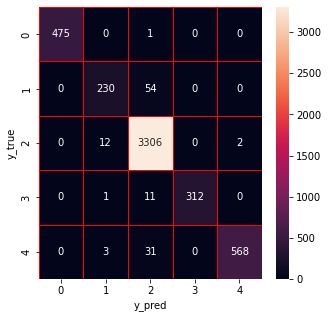

In [36]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [37]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:26<00:00,  1.33s/trial, best loss: -0.9868158210147823]
XGBoost: Hyperopt estimated optimum {'learning_rate': -0.8293364946674092, 'max_depth': 29.0, 'n_estimators': 85.0}


Accuracy of XGBoost: 0.9864163004394726
Precision of XGBoost: 0.9863498645291989
Recall of XGBoost: 0.9864163004394726
F1-score of XGBoost: 0.9863308460149923
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.95      0.91      0.93       284
           2       0.99      1.00      0.99      3320
           3       0.99      0.97      0.98       324
           4       0.99      0.98      0.99       602

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.98      5006
weighted avg       0.99      0.99      0.99      5006



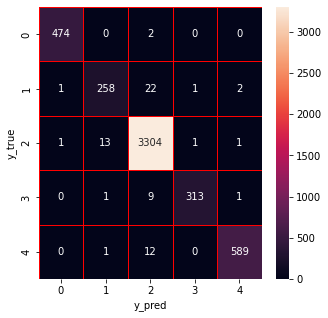

In [38]:
xg = xgb.XGBClassifier(learning_rate= 0.7340229699980686, n_estimators = 70, max_depth = 14)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [39]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

Accuracy of RF: 0.9786256492209349
Precision of RF: 0.9783728324411195
Recall of RF: 0.9786256492209349
F1-score of RF: 0.9783273218592021
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.92      0.84      0.88       284
           2       0.98      0.99      0.99      3320
           3       0.98      0.97      0.97       324
           4       0.99      0.96      0.98       602

    accuracy                           0.98      5006
   macro avg       0.97      0.95      0.96      5006
weighted avg       0.98      0.98      0.98      5006



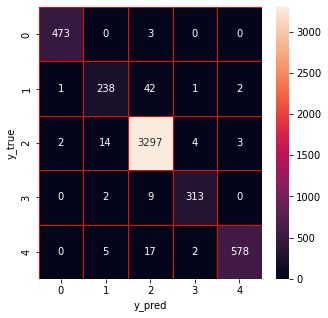

In [40]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) 
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [41]:
# Hyperparameter optimization of random forest
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = RandomForestClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 20/20 [00:40<00:00,  2.03s/trial, best loss: -0.9814222932481023]
Random Forest: Hyperopt estimated optimum {'criterion': 0, 'max_depth': 36.0, 'max_features': 20.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 163.0}


Accuracy of RF: 0.9826208549740312
Precision of RF: 0.9825170210475445
Recall of RF: 0.9826208549740312
F1-score of RF: 0.9824050160075237
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       476
           1       0.93      0.86      0.90       284
           2       0.98      1.00      0.99      3320
           3       1.00      0.96      0.98       324
           4       1.00      0.97      0.98       602

    accuracy                           0.98      5006
   macro avg       0.98      0.96      0.97      5006
weighted avg       0.98      0.98      0.98      5006



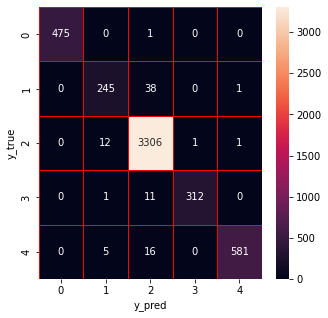

In [42]:
rf_hpo = RandomForestClassifier(n_estimators = 71, min_samples_leaf = 1, max_depth = 46, min_samples_split = 9, max_features = 20, criterion = 'entropy')
rf_hpo.fit(X_train,y_train)
rf_score=rf_hpo.score(X_test,y_test)
y_predict=rf_hpo.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [43]:
rf_train=rf_hpo.predict(X_train)
rf_test=rf_hpo.predict(X_test)

Accuracy of DT: 0.9804234918098282
Precision of DT: 0.9803306548752598
Recall of DT: 0.9804234918098282
F1-score of DT: 0.9803707538039446
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       476
           1       0.90      0.88      0.89       284
           2       0.99      0.99      0.99      3320
           3       0.97      0.96      0.97       324
           4       0.97      0.98      0.97       602

    accuracy                           0.98      5006
   macro avg       0.96      0.96      0.96      5006
weighted avg       0.98      0.98      0.98      5006



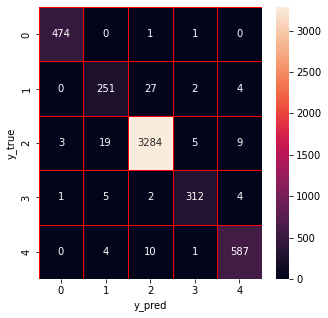

In [44]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train) 
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [45]:
# Hyperparameter optimization of decision tree
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = DecisionTreeClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50)
print("Decision tree: Hyperopt estimated optimum {}".format(best))

100%|███████████████████████████████████████████████| 50/50 [00:01<00:00, 28.47trial/s, best loss: -0.9804234918098282]
Decision tree: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 22.0, 'max_features': 14.0, 'min_samples_leaf': 1.0, 'min_samples_split': 4.0}


Accuracy of DT: 0.9788254095085897
Precision of DT: 0.9789775421070162
Recall of DT: 0.9788254095085897
F1-score of DT: 0.9788752310326536
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       476
           1       0.86      0.87      0.86       284
           2       0.99      0.99      0.99      3320
           3       0.99      0.96      0.98       324
           4       0.98      0.97      0.97       602

    accuracy                           0.98      5006
   macro avg       0.96      0.96      0.96      5006
weighted avg       0.98      0.98      0.98      5006



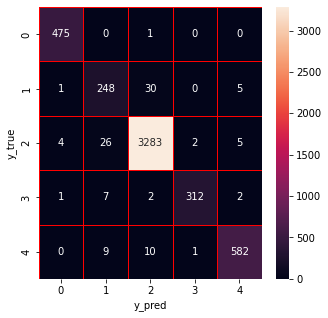

In [46]:
dt_hpo = DecisionTreeClassifier(min_samples_leaf = 2, max_depth = 47, min_samples_split = 3, max_features = 19, criterion = 'gini')
dt_hpo.fit(X_train,y_train)
dt_score=dt_hpo.score(X_test,y_test)
y_predict=dt_hpo.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [47]:
dt_train=dt_hpo.predict(X_train)
dt_test=dt_hpo.predict(X_test)

Accuracy of ET: 0.9744306831801838
Precision of ET: 0.9741137421142624
Recall of ET: 0.9744306831801838
F1-score of ET: 0.974187425690227
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.90      0.84      0.87       284
           2       0.98      0.99      0.98      3320
           3       0.97      0.96      0.96       324
           4       0.97      0.96      0.96       602

    accuracy                           0.97      5006
   macro avg       0.96      0.95      0.95      5006
weighted avg       0.97      0.97      0.97      5006



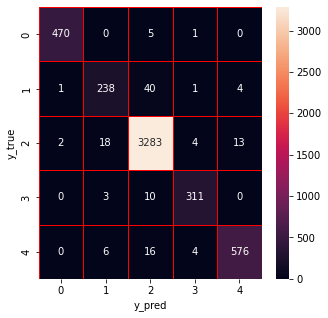

In [48]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train) 
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [49]:
# Hyperparameter optimization of extra trees
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
# Define the objective function
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'max_features': int(params['max_features']),
        "min_samples_split":int(params['min_samples_split']),
        "min_samples_leaf":int(params['min_samples_leaf']),
        "criterion":str(params['criterion'])
    }
    clf = ExtraTreesClassifier( **params)
    clf.fit(X_train,y_train)
    score=clf.score(X_test,y_test)

    return {'loss':-score, 'status': STATUS_OK }
# Define the hyperparameter configuration space
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_depth': hp.quniform('max_depth', 5, 50, 1),
    "max_features":hp.quniform('max_features', 1, 20, 1),
    "min_samples_split":hp.quniform('min_samples_split',2,11,1),
    "min_samples_leaf":hp.quniform('min_samples_leaf',1,11,1),
    "criterion":hp.choice('criterion',['gini','entropy'])
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("Random Forest: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████| 20/20 [00:21<00:00,  1.07s/trial, best loss: -0.982820615261686]
Random Forest: Hyperopt estimated optimum {'criterion': 1, 'max_depth': 21.0, 'max_features': 18.0, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 141.0}


Accuracy of ET: 0.9872153415900919
Precision of ET: 0.9871376272313415
Recall of ET: 0.9872153415900919
F1-score of ET: 0.987128876275123
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.95      0.91      0.93       284
           2       0.99      1.00      0.99      3320
           3       0.99      0.97      0.98       324
           4       0.99      0.98      0.99       602

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.98      5006
weighted avg       0.99      0.99      0.99      5006



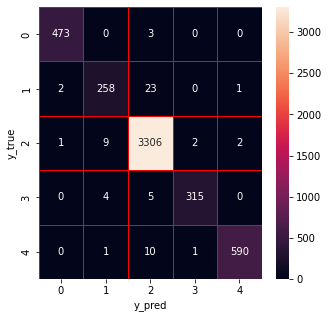

In [50]:
et_hpo = ExtraTreesClassifier(n_estimators = 53, min_samples_leaf = 1, max_depth = 31, min_samples_split = 5, max_features = 20, criterion = 'entropy')
et_hpo.fit(X_train,y_train) 
et_score=et_hpo.score(X_test,y_test)
y_predict=et_hpo.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [51]:
et_train=et_hpo.predict(X_train)
et_test=et_hpo.predict(X_test)

In [52]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,2,2,2,2
1,1,1,1,1
2,4,4,4,4
3,4,4,4,4
4,1,1,1,1


In [53]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [54]:
dt_train.shape

(20022, 1)

In [55]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.986016779864163
Precision of Stacking: 0.98594229500457
Recall of Stacking: 0.986016779864163
F1-score of Stacking: 0.9859273804429787
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.94      0.90      0.92       284
           2       0.99      1.00      0.99      3320
           3       0.99      0.97      0.98       324
           4       0.99      0.98      0.99       602

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.97      5006
weighted avg       0.99      0.99      0.99      5006



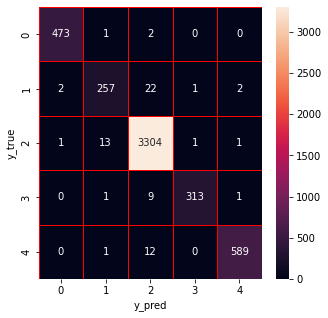

In [56]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [57]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score, StratifiedKFold
def objective(params):
    params = {
        'n_estimators': int(params['n_estimators']), 
        'max_depth': int(params['max_depth']),
        'learning_rate':  abs(float(params['learning_rate'])),

    }
    clf = xgb.XGBClassifier( **params)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    score = accuracy_score(y_test, y_pred)

    return {'loss':-score, 'status': STATUS_OK }

space = {
    'n_estimators': hp.quniform('n_estimators', 10, 100, 5),
    'max_depth': hp.quniform('max_depth', 4, 100, 1),
    'learning_rate': hp.normal('learning_rate', 0.01, 0.9),
}

best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20)
print("XGBoost: Hyperopt estimated optimum {}".format(best))

100%|████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.56trial/s, best loss: -0.986016779864163]
XGBoost: Hyperopt estimated optimum {'learning_rate': -1.1023538271348998, 'max_depth': 40.0, 'n_estimators': 10.0}


Accuracy of XGBoost: 0.9854174990011986
Precision of XGBoost: 0.9855343093957123
Recall of XGBoost: 0.9854174990011986
F1-score of XGBoost: 0.9854472270923815
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       476
           1       0.91      0.93      0.92       284
           2       0.99      0.99      0.99      3326
           3       1.00      0.97      0.98       322
           4       0.99      0.98      0.99       598

    accuracy                           0.99      5006
   macro avg       0.98      0.97      0.97      5006
weighted avg       0.99      0.99      0.99      5006



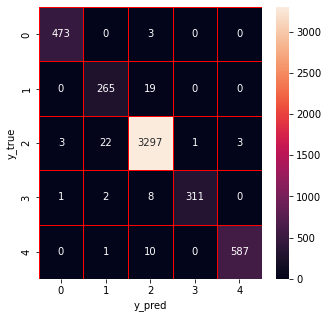

In [66]:
xg = xgb.XGBClassifier(learning_rate= 0.19229249758051492, n_estimators = 30, max_depth = 36)
xg.fit(x_train,y_train)
xg_score=xg.score(x_test,y_test)
y_predict=xg.predict(x_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted') 
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()